In [57]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt 
import torch
import matplotlib as mpl
import torchquad
torch.set_default_dtype(torch.float32)
torch.set_printoptions(precision=10)
device=torch.device('cuda' if torch.cuda.is_available() else print('error no cuda') )
torchquad.set_up_backend("torch", data_type="float64")
torch.set_printoptions(edgeitems=100)
torch.cuda.empty_cache()
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 20})
DPI=350

In [58]:
#Parameter in micrometer
wl_TPA=.900
wl_ill=0.488
wl_det=0.520
wl_p=0.797
wl_S=1.031
num_ap = 1.2 #numerical aperture
ref_index= 1.33 #refractive index
M=63 # magnification
pinhole_radius_airy=1 #pin hole radius in airy
pinhole_radius=pinhole_radius_airy*0.61*wl_det/(num_ap) #pin hole radius in micrometer (in image space)
ap_durch_f=np.tan(np.arcsin(num_ap/ref_index))

#Discretize space
r_min=-4
r_max=4
r_num=901
r_array=torch.linspace(r_min,r_max,r_num)

z_min=-3
z_max=3
z_num=801
z_array=torch.linspace(z_min,z_max,z_num)

pinhole_array=torch.tile(torch.where(torch.abs(r_array) <= pinhole_radius, torch.tensor(1.0), torch.tensor(0.0)),(z_num,1)).T
#save paramters as dict in a numpy file
params = {
    "wl_TPA": wl_TPA,
    "wl_ill": wl_ill,
    "wl_det": wl_det,
    "wl_p": wl_p,
    "wl_S": wl_S,
    "num_ap": num_ap,
    "ref_index": ref_index,
    "M": M,
    "pinhole_radius_airy": pinhole_radius_airy,
    "pinhole_radius": pinhole_radius,
    "ap_durch_f": ap_durch_f,
    "r_min": r_min,
    "r_max": r_max,
    "r_num": r_num,
    "z_min": z_min,
    "z_max": z_max,
    "z_num": z_num
}
np.savez("params", **params)

In [59]:
def spot_size(z,w0=1,zR=2):
    return w0*(np.sqrt(1+(z/zR)**2))
def gaussian_beam(r,z,w0=0.3,zR=1):
    return np.exp(-2*r[:,np.newaxis]**2/spot_size(z[np.newaxis,:],w0=w0,zR=zR)**2)
def bessel_beam(r):
    return sp.special.j0(r)**2

In [60]:
gausslegendre=torchquad.GaussLegendre()
N=51
int_domain=torch.tensor([[0,1]])
integrate_jit_compiled_parts = gausslegendre.get_jit_compiled_integrate(dim=1, N=N, backend="torch")
def integrand(v,u,rho):
        return rho[:,torch.newaxis,torch.newaxis]*torch.special.bessel_j0(v[torch.newaxis,:,torch.newaxis]*rho[:,torch.newaxis,torch.newaxis])*torch.exp(-1/2*1j*u[torch.newaxis,torch.newaxis,:]*rho[:,torch.newaxis,torch.newaxis]**2)
def born_wolf(r,z,wl):
    v=2*np.pi/wl*(ap_durch_f)*r
    u=2*np.pi/wl*(ap_durch_f)**2*z
    return -1j*2*torch.exp(1j*2*torch.pi/wl*z[torch.newaxis,:])*integrate_jit_compiled_parts(lambda x: integrand(v, u, x[:,0]), integration_domain=int_domain)

In [61]:
h_ill=born_wolf(r_array, z_array, wl_ill)
h_det=born_wolf(r_array, z_array, wl_det)
h_ill_2p=born_wolf(r_array, z_array, wl_TPA)
PSF_srs = torch.abs(born_wolf(r_array, z_array, wl_p))**2*torch.abs(born_wolf(r_array, z_array, wl_S))**2

In [62]:
PSF_conventional = (torch.abs(h_det)**2).detach().cpu().numpy()
np.savetxt(f'psf_conventional.csv', PSF_conventional, delimiter=',')
I_det_confocal = sp.signal.fftconvolve((torch.abs(h_det)**2).detach().cpu().numpy(), pinhole_array.detach().cpu().numpy(), mode='same', axes=0)
I_det_confocal = I_det_confocal/np.max(I_det_confocal)
PSF_confocal = np.abs(h_ill.detach().cpu().numpy())**2*I_det_confocal
np.savetxt(f'psf_confocal.csv', PSF_confocal, delimiter=',')
PSF_confocal_ideal= (torch.abs(h_ill)**2*torch.abs(h_det)**2).detach().cpu().numpy()
np.savetxt(f'psf_confocal_ideal.csv', PSF_confocal_ideal, delimiter=',')
PSF_2p_conventional = (torch.abs(h_ill_2p)**4).detach().cpu().numpy()
np.savetxt(f'psf_2p_conventional.csv', PSF_2p_conventional, delimiter=',')
PSF_2p_confocal = (torch.abs(h_ill_2p)**4*torch.abs(h_det)**2).detach().cpu().numpy()
np.savetxt(f'psf_2p_confocal.csv', PSF_2p_confocal, delimiter=',')
PSF_srs = (torch.abs(born_wolf(r_array, z_array, wl_p))**2*torch.abs(born_wolf(r_array, z_array, wl_S))**2).clone().detach().cpu().numpy()
np.savetxt(f'psf_srs.csv', PSF_srs, delimiter=',')

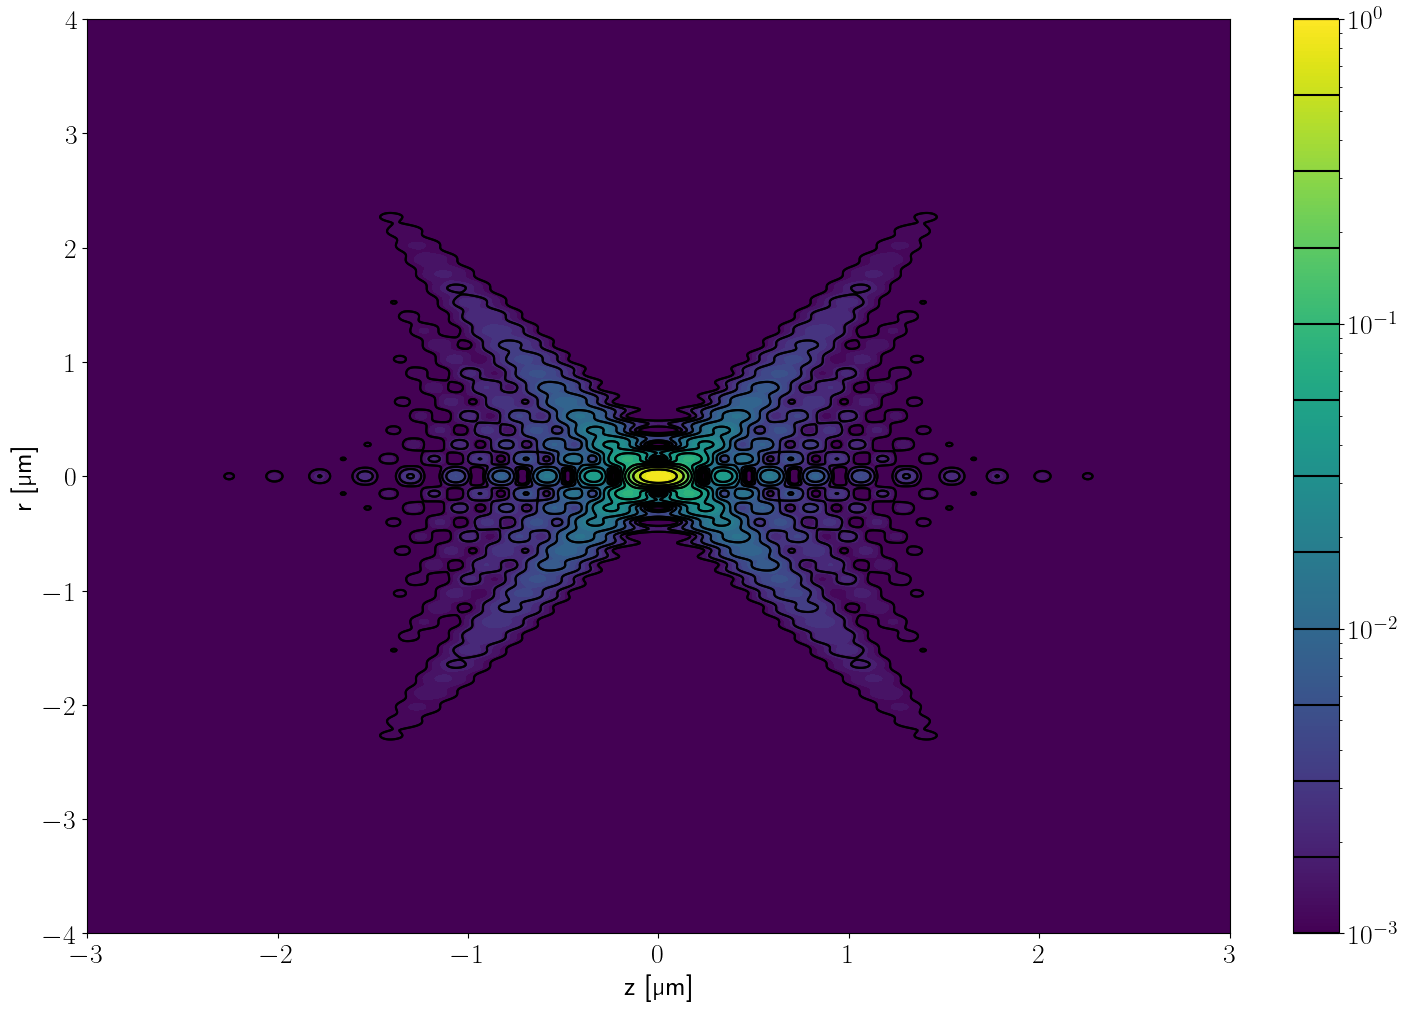

In [63]:
cmap_norm=mpl.colors.LogNorm(1e-3,1)
cmap=mpl.cm.viridis
contour_levels=np.geomspace(1e-3,1,num=13)
contourf_levels=np.geomspace(1e-3,1,num=31)
cmap=mpl.cm.viridis
fig,ax=plt.subplots(layout='constrained',figsize=(14,10))
plt.contourf(z_array.cpu(), r_array.cpu(), PSF_conventional, levels=contourf_levels, cmap=cmap, norm=cmap_norm, extend='min')
plt.contourf(z_array.cpu(), -r_array.cpu(), PSF_conventional , levels=contourf_levels, cmap=cmap, norm=cmap_norm, extend='min')
c1=plt.contour(z_array.cpu(), r_array.cpu(), PSF_conventional, levels=contour_levels, colors='k', linestyles='-')
c2=plt.contour(z_array.cpu(), -r_array.cpu(), PSF_conventional, levels=contour_levels, colors='k', linestyles='-')
plt.xlabel(r'z [\textmu m]')
plt.ylabel(r'r [\textmu m]')
#plt.xlim([-4,4])
#plt.ylim([-2,2])
cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=cmap_norm, cmap=cmap),ax=ax, orientation='vertical', )
cbar.add_lines(c1)

C:\Users\dan20\AppData\Local\Temp\ipykernel_18712\1316727142.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


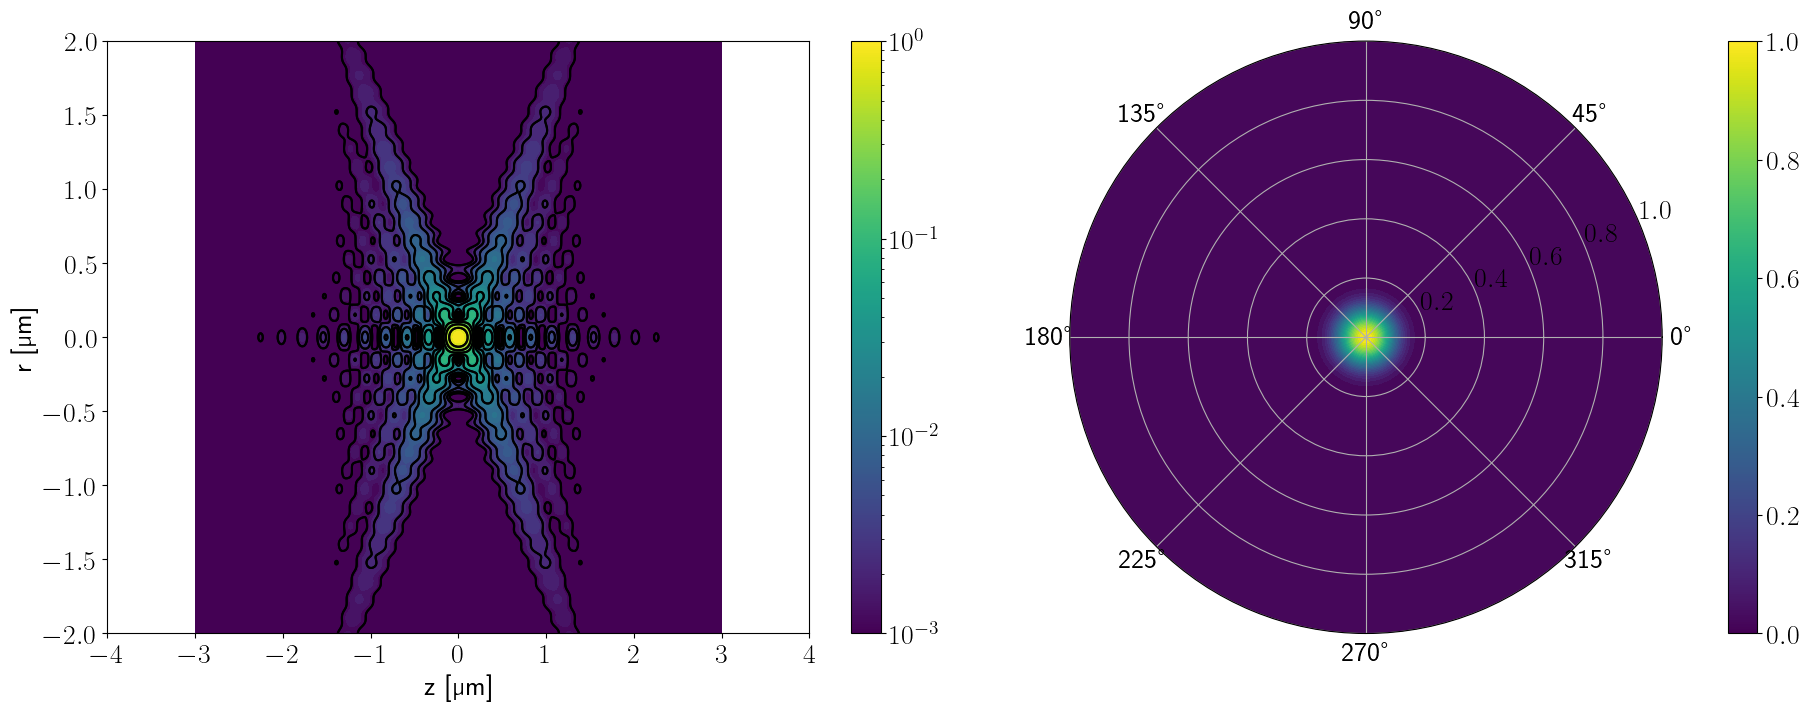

In [64]:
theta_num=360
theta_array = np.linspace(0,360,theta_num)
cmap_norm=mpl.colors.LogNorm(1e-3,1)
cmap=mpl.cm.viridis
contour_levels=np.geomspace(1e-3,1,num=11)
contourf_levels=np.geomspace(1e-3,1,num=31)
cmap=mpl.cm.viridis

fig, axs =plt.subplot_mosaic([['0','1']],per_subplot_kw={('1'):{'projection':'polar'},},layout='constrained',figsize=(18,7))
ax=axs['0']
ax.contourf(z_array.cpu(), r_array.cpu(), PSF_conventional, levels=contourf_levels, cmap=cmap, norm=cmap_norm, extend='min')
ax.contourf(z_array.cpu(), -r_array.cpu(), PSF_conventional , levels=contourf_levels, cmap=cmap, norm=cmap_norm, extend='min')
c1=ax.contour(z_array.cpu(), r_array.cpu(), PSF_conventional, levels=contour_levels, colors='k', linestyles='-')
c2=ax.contour(z_array.cpu(), -r_array.cpu(), PSF_conventional, levels=contour_levels, colors='k', linestyles='-')
ax.set_xlabel(r'z [\textmu m]')
ax.set_ylabel(r'r [\textmu m]')
ax.set_xlim([-4,4])
ax.set_ylim([-2,2])
cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=cmap_norm, cmap=cmap),ax=ax, orientation='vertical', )

ax=axs['1']
ax.contourf(theta_array, r_array.cpu(), np.tile(PSF_srs[:,int(z_num/2)],(theta_num,1)).T, levels=np.linspace(0,1,num=31),cmap=cmap,norm=mpl.colors.Normalize(0,1),extend='min')
cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0,1), cmap=cmap),ax=ax, orientation='vertical', )
ax.set_ylim([0,1])
fig.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

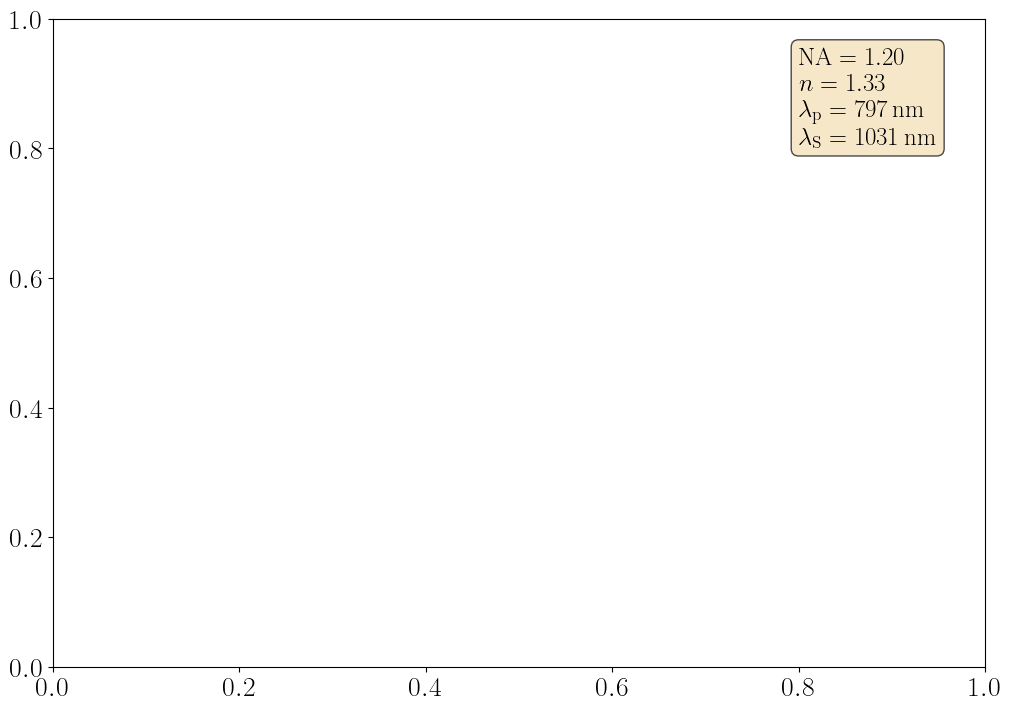

In [65]:
fig, ax =plt.subplots(figsize=(10,7),layout='constrained', frameon=True)

boxcontent = '\n'.join((
    r'$\mathrm{NA}=%.2f$' % (num_ap, ),
    r'$n=%.2f$' % (ref_index, ),
    r'$\lambda_{\mathrm{p}}=%.0f\,\mathrm{nm}$' % (wl_p*10**3, ),
    r'$\lambda_{\mathrm{S}}=%.0f\,\mathrm{nm}$' % (wl_S*10**3, )))
boxprops=dict(boxstyle='round', facecolor='wheat', alpha=0.7)
plt.text(0.8, 0.8, boxcontent, transform=ax.transAxes, fontsize=18,
        verticalalignment='bottom', bbox=boxprops)

plt.plot(z_array, np.angle((1j*h_det*2*torch.exp(-1j*2*torch.pi/wl_det*z_array[torch.newaxis,:]))[int(r_num/2),:]), color='tab:blue')
#plt.plot(-r_array, PSF_srs[:,int(z_num/2)],color='tab:blue')
plt.xlabel(r'r [\textmu m]')
plt.ylabel(r'Point Spread Function [a.u.]')
plt.title('Lateral extent of the Point Spread Function in SRS Microscopy')
#plt.xlim(-0.8,0.8)
#plt.ylim(-np.pi,np.pi)
plt.grid(visible=True)
#fig.savefig('PSFs_zplane_integrated.svg',bbox_inches='tight')
#fig.savefig('PSFs_zplane_integrated.png',dpi=DPI,bbox_inches='tight')
plt.show()

In [ ]:
fig, ax =plt.subplots(figsize=(10,7),layout='constrained', frameon=True)

boxcontent = '\n'.join((
    r'$\mathrm{NA}=%.2f$' % (num_ap, ),
    r'$n=%.2f$' % (ref_index, ),
    r'$\lambda_{\mathrm{p}}=%.0f\,\mathrm{nm}$' % (wl_p*10**3, ),
    r'$\lambda_{\mathrm{S}}=%.0f\,\mathrm{nm}$' % (wl_S*10**3, )))
boxprops=dict(boxstyle='round', facecolor='wheat', alpha=0.7)
plt.text(0.8, 0.8, boxcontent, transform=ax.transAxes, fontsize=18,
        verticalalignment='bottom', bbox=boxprops)

plt.plot(r_array, PSF_srs[:,int(z_num/2)],color='tab:blue')
#plt.plot(-r_array, PSF_srs[:,int(z_num/2)],color='tab:blue')
plt.xlabel(r'r [\textmu m]')
plt.ylabel(r'Point Spread Function [a.u.]')
plt.title('Lateral extent of the Point Spread Function in SRS Microscopy')
plt.xlim(-0.8,0.8)
plt.ylim(0.0,1.1)
plt.grid(visible=True)
#fig.savefig('PSFs_zplane_integrated.svg',bbox_inches='tight')
#fig.savefig('PSFs_zplane_integrated.png',dpi=DPI,bbox_inches='tight')
plt.show()

In [ ]:
theta_num=360
theta_array = torch.linspace(0,360,theta_num)
cmap_norm=mpl.colors.LogNorm(1e-3,1)
cmap=mpl.cm.viridis
contour_levels=np.geomspace(1e-3,1,num=11)
contourf_levels=np.geomspace(1e-3,1,num=31)
cmap=mpl.cm.viridis

fig, axs =plt.subplot_mosaic([['0','1']],per_subplot_kw={('1'):{'projection':'polar'},},layout='constrained',figsize=(18,7))
fig.suptitle('Confocal PSF')
ax=axs['0']
ax.contourf(z_array, r_array, PSF_confocal , levels=contourf_levels, cmap=cmap, norm=cmap_norm, extend='min')
#ax.contourf(z_array, -r_array, PSF_confocal , levels=contourf_levels, cmap=cmap, norm=cmap_norm, extend='min')
c1=ax.contour(z_array, r_array, PSF_confocal, levels=contour_levels, colors='k', linestyles='-')
#c2=ax.contour(z_array, -r_array, PSF_confocal, levels=contour_levels, colors='k', linestyles='-')
ax.set_xlabel(r'z [\textmu m]')
ax.set_ylabel(r'r [\textmu m]')
ax.set_xlim([-2,2])
ax.set_ylim([-1.5,1.5])
cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=cmap_norm, cmap=cmap),ax=ax, orientation='vertical', )

ax=axs['1']
ax.set_title(r'$z=0$ plane')
ax.contourf(theta_array, r_array, np.tile(PSF_confocal[:,int(z_num/2)],(theta_num,1)).T, levels=np.linspace(0,1,num=31),cmap=cmap,norm=mpl.colors.Normalize(0,1),extend='min')
cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0,1), cmap=cmap),ax=ax, orientation='vertical', )
ax.set_ylim([0,1.5])
#ax.r_label(r'$r$ [\textmu m]')
ax.set_xlabel(r'$\theta$ [degree]')
fig.show()


In [ ]:
fig, ax =plt.subplots(figsize=(10,7),layout='constrained', frameon=True)
boxprops=dict(boxstyle='square', facecolor='white', alpha=0.7)
boxcontent = '\n'.join((
    r'$\mathrm{NA}=%.2f$' % (num_ap, ),
    r'$n=%.2f$' % (ref_index, ),
    r'$\lambda_{\mathrm{ill}}=%.0f\,\mathrm{nm}$' % (wl_ill*10**3, ),
    r'$\lambda_{\mathrm{det}}=%.0f\,\mathrm{nm}$' % (wl_det*10**3, ),
    r'$r_{\mathrm{pinhole}}=%.0f\,\mathrm{A.U.}$' % (pinhole_radius_airy, )))
boxprops=dict(boxstyle='round', facecolor='wheat', alpha=0.7)
plt.text(0.8, 0.9, boxcontent, transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=boxprops)

plt.plot(r_array, PSF_confocal[:,int(z_num/2)],color='tab:blue', label='Finite Confocal Pinhole')
plt.plot(r_array, PSF_confocal_ideal[:,int(z_num/2)],color='tab:red', label='Ideal Confocal Pinhole')
plt.xlabel(r'r [\textmu m]')
plt.ylabel(r'Point Spread Function [a.u.]')
plt.title('Lateral extent of the Point Spread Function in Confocal Microscopy')
plt.legend(loc='upper left')
plt.xlim(-0.8,0.8)
plt.ylim(0.0,1.1)
plt.grid(visible=True)
#fig.savefig('PSFs_zplane_integrated.svg',bbox_inches='tight')
#fig.savefig('PSFs_zplane_integrated.png',dpi=DPI,bbox_inches='tight')
plt.show()

In [ ]:
pinhole_radius=.1
pinhole_array=torch.tile(torch.where(torch.abs(r_array) <= pinhole_radius, torch.tensor(1.0), torch.tensor(0.0)),(z_num,1)).T
test=sp.signal.fftconvolve(PSF_confocal, pinhole_array, mode='same', axes=0)
test=test/np.max(test)

In [ ]:
theta_num=360
theta_array = torch.linspace(0,360,theta_num)
cmap_norm=mpl.colors.LogNorm(1e-3,1)
cmap=mpl.cm.viridis
contour_levels=np.geomspace(1e-3,1,num=11)
contourf_levels=np.geomspace(1e-3,1,num=31)
cmap=mpl.cm.viridis

fig, axs =plt.subplot_mosaic([['0','1']],per_subplot_kw={('1'):{'projection':'polar'},},layout='constrained',figsize=(18,7))
ax=axs['0']
ax.contourf(z_array, r_array, test , levels=contourf_levels, cmap=cmap, norm=cmap_norm, extend='min')
#ax.contourf(z_array, -r_array, PSF_confocal , levels=contourf_levels, cmap=cmap, norm=cmap_norm, extend='min')
c1=ax.contour(z_array, r_array, test, levels=contour_levels, colors='k', linestyles='-')
#c2=ax.contour(z_array, -r_array, PSF_confocal, levels=contour_levels, colors='k', linestyles='-')
ax.set_xlabel(r'z [\textmu m]')
ax.set_ylabel(r'r [\textmu m]')
ax.set_xlim([-2,2])
ax.set_ylim([-1.5,1.5])
cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=cmap_norm, cmap=cmap),ax=ax, orientation='vertical', )

ax=axs['1']
ax.contourf(theta_array, r_array, np.tile(test[:,int(z_num/2)],(theta_num,1)).T, levels=np.linspace(0,1,num=31),cmap=cmap,norm=mpl.colors.Normalize(0,1),extend='min')
cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=cmap_norm, cmap=cmap),ax=ax, orientation='vertical', )
ax.set_ylim([0,1.5])
fig.show()

In [ ]:
fig, ax =plt.subplots(figsize=(10,7),layout='constrained', frameon=True)
plt.plot(r_array, test[:,300], color='tab:blue')
plt.plot(r_array, pinhole_array[:,0], color='tab:red')
plt.plot(r_array,PSF_confocal[:,300], color='tab:green')
plt.xlabel(r'r [\textmu m]')
plt.ylabel(r'Point Spread Function [a.u.]')
plt.title('Lateral extent of the Point Spread Function in Confocal Microscopy')
plt.xlim(-0.8,0.8)
plt.ylim(0.0,1.1)
plt.grid(visible=True)
#fig.savefig('PSFs_zplane_integrated.svg',bbox_inches='tight')
#fig.savefig('PSFs_zplane_integrated.png',dpi=DPI,bbox_inches='tight')
plt.show()